In [1]:
import os
import warnings

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import daft
import pandas as pd

from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats

warnings.simplefilter(action="ignore", category=FutureWarning)

%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
np.random.seed(1234)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data_dir = '/home/telescreen/Workspace/fun/pymc-devs-resources/Rethinking_2/Data/'
data = pd.read_csv(os.path.join(data_dir, 'WaffleDivorce.csv'), sep=';')
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [3]:
# The data includes 16 different metrics from 50 states
data.shape

(50, 13)

Correlation in general is not surprising. In large data sets, every pair of variables has a statistically discernible non-zero correlation. Since most correlations do not indicate causal relationships, we need tools for distinguishing mere association from evidence of causation. **MULTIPLE REGRESSION** tries to solve this causal problem by

(1) Statistical control for confounds. A *confound* is something that misleads us about a causal influence.
(2) Multiple causation. When causation is multiple, one cause can hide another.
(3) Interactions. The importance of one variable may depend upon another.

Using multiple regression to deal with simple confounds and to take multiple measurements of assocation. We can include any arbitrary number of *main effects* in our linear model of the Gaussian mean. These main effects are additive combinations of variables, the simplest type of multiple variable model.

We think formally about **CAUSAL INFERENCE** and introduce graphical causal models as a way to design and interpret regression models.

In the below 2 graphs, we see that Divorce Rate is associated with both marriage rate and median age at marriage 

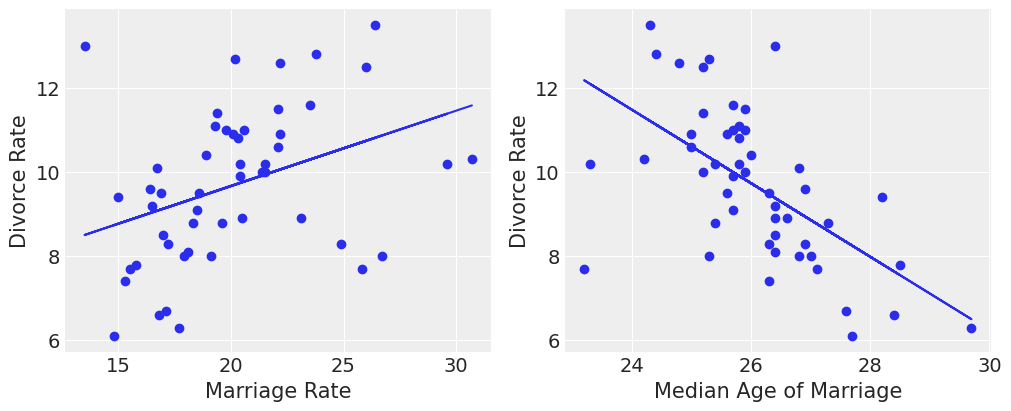

In [4]:
from sklearn.linear_model import LinearRegression

reg_MD = LinearRegression().fit(data.Marriage.values.reshape(-1, 1), data.Divorce.values)
reg_AD = LinearRegression().fit(data.MedianAgeMarriage.values.reshape(-1, 1), data.Divorce.values)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(data.Marriage, data.Divorce)
ax[0].set_xlabel('Marriage Rate')
ax[0].set_ylabel('Divorce Rate')
ax[0].plot(data.Marriage, reg_MD.predict(data.Marriage.values.reshape(-1, 1)))
ax[1].scatter(data.MedianAgeMarriage, data.Divorce)
ax[1].set_xlabel('Median Age of Marriage')
ax[1].set_ylabel('Divorce Rate')
ax[1].plot(data.MedianAgeMarriage, reg_AD.predict(data.MedianAgeMarriage.values.reshape(-1, 1)));

## Spurious association
Model. $D_i$ is the standardized (zero centered, standard deviation one) divorce rate for State $i$, $A_i$ is State $i$'s standardized median age at marriage.

$$ D_i \sim Normal(\mu, \sigma) $$
$$ \mu_i = \alpha + \beta_AA_i $$
$$ \alpha \sim Normal(0, 0.2) $$
$$ \beta_A \sim Normal(0, 0.5) $$
$$ \sigma \sim Exponential(1) $$

Since the outcome and the predictor are both standardized, the intercept $\alpha$ should end up very close to zero. What does the prior slope $\beta_A$ imply? If $\beta_A = 1$, that would imply that a change of one standard deviation in age at marriage is associated likewise with a change of one standard deviation in divorce.

In [5]:
def standardize(series):
    std_series = (series - series.mean()) / series.std()
    return std_series

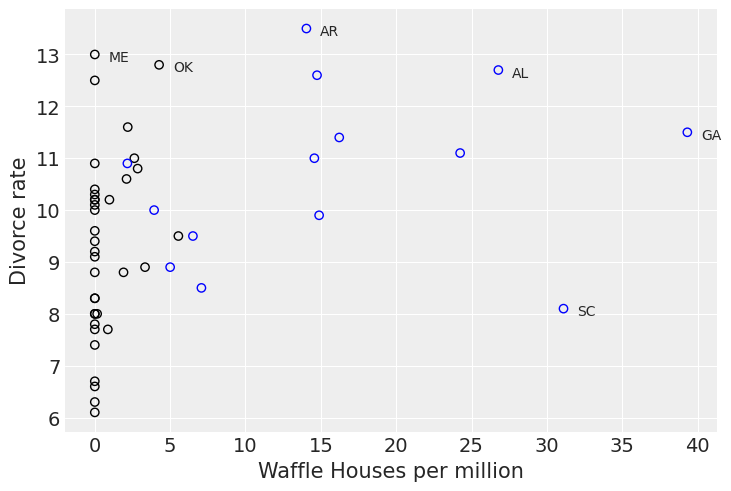

In [6]:
# Fig 5.1, missing mean
fig, ax = plt.subplots()

# assign colours to confederate states
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WaffleHouses"] / data["Population"],
    data["Divorce"],
    lw=1,
    color=(0, 0, 0, 0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")
# take only the states with Divorce rate over 12.6 or 
# number of Waffle houses per million inhabitants over 30
selection = data[
    (data["Divorce"] > 12.6) | (data["WaffleHouses"] / data["Population"] > 30)
]

# label those points
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(
        f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5)
    )

In [7]:
data['Marriage_std'] = standardize(data.Marriage)
data['MedianAgeMarriage_std'] = standardize(data.MedianAgeMarriage)
data['Divorce_std'] = standardize(data.Divorce)

### Regression: Divorce Rate against Age of Marriage

In [8]:
with pm.Model() as m_5_1:
    a = pm.Normal('a', mu=0, sigma=0.2)
    bA = pm.Normal('bA', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bA*data.MedianAgeMarriage_std)
    
    divorce_rate_std = pm.Normal(
        'divorce_rate_std', mu=mu, sigma=sigma, observed=data.Divorce_std)
    prior_trace = pm.sample_prior_predictive()
    m_5_1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


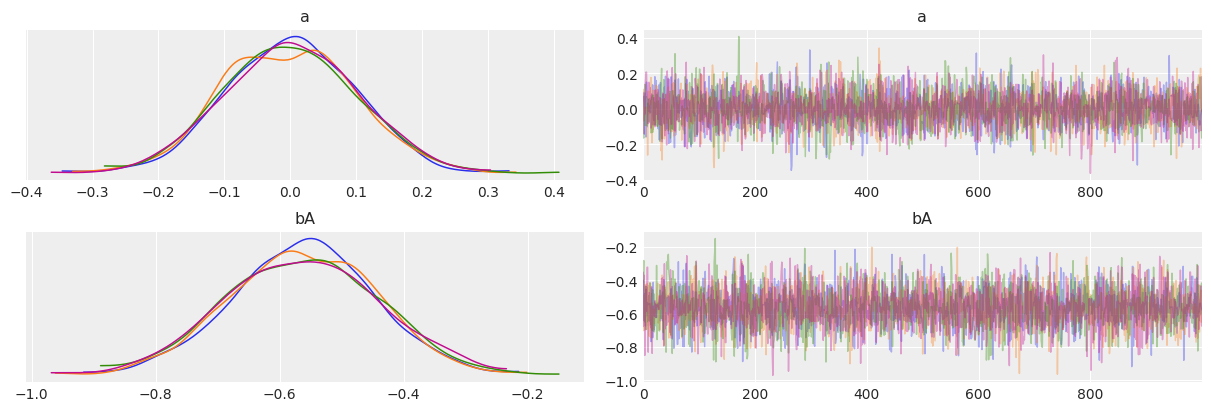

In [9]:
az.plot_trace(m_5_1_trace, var_names=['a', 'bA']);

In [10]:
age_std_seq = np.linspace(-3, 3.2, 30)
mu_pred = np.zeros((len(age_std_seq), len(m_5_1_trace)*m_5_1_trace.nchains))
for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_1_trace['a'] + m_5_1_trace['bA']*age_std

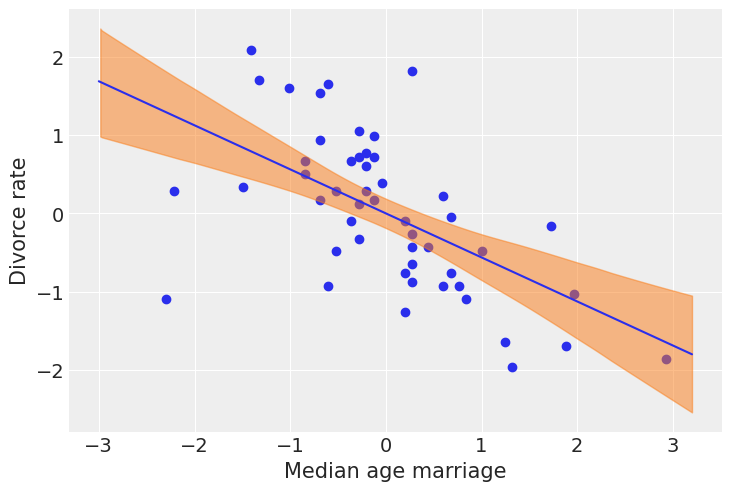

In [11]:
mu_mean = mu_pred.mean(axis=1)
plt.scatter(data.MedianAgeMarriage_std, data.Divorce_std)
plt.plot(age_std_seq, mu_mean)
ax = az.plot_hpd(age_std_seq, mu_pred.T, ax=plt.gca())
ax.set_xlabel('Median age marriage')
ax.set_ylabel('Divorce rate');

### Regression: Divorce Rate against Marriage Rate

In [12]:
with pm.Model() as m_5_2:
    a = pm.Normal('a', mu=0, sigma=0.2)
    bM = pm.Normal('bM', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bM*data.Marriage_std)
    
    divorce_rate_std = pm.Normal(
        'divorce_rate_std', mu=mu, sigma=sigma, observed=data.Divorce_std)
    prior_trace = pm.sample_prior_predictive()
    m_5_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


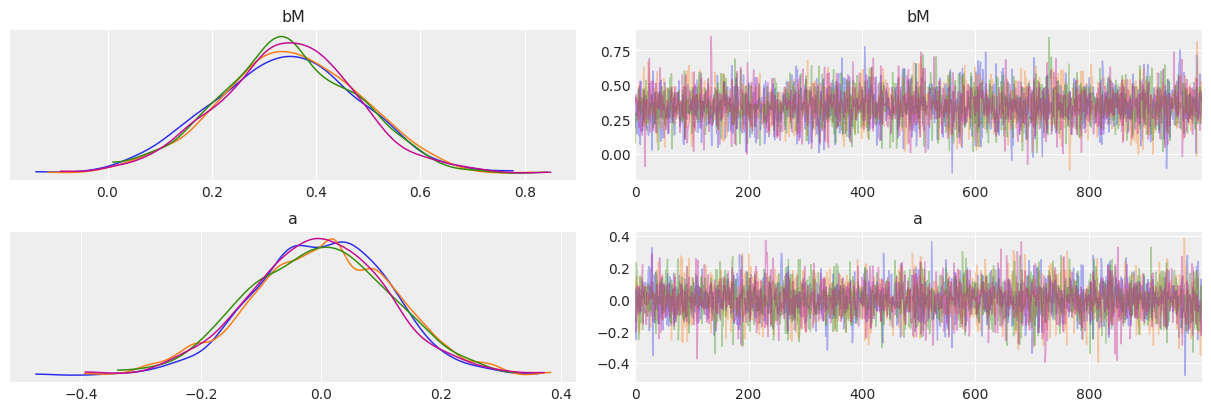

In [13]:
az.plot_trace(m_5_2_trace, var_names=['bM', 'a']);

**Think before you regress:** There are three observed variables in play: divorce rate (D), marriage rate (M), and the median age at marriage (A) in each State. To understand this, it is helpful to introduce a particular type of causal graph known as a DAG. It's helpful to introduce a particular type of causal graph known as a **DAG**, short for **DIRECTED ACYCLIC GRAPH**. *Graph* means it is nodes and connections. *Directed* means the connections have arrows that indicate directions of causal influence. And *Acyclic* means that causes do not eventually flow back on themselves. 

/home/telescreen/miniconda3/envs/data/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


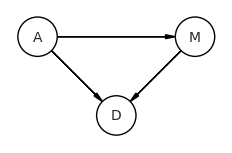

In [14]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [15]:
print(dag5_1.get_distribution())

P(A)P(M|A)P(D|A,M)


How do we understand all this ?

He explains that here we may want to think causally.

Few interesting assumptions (or rather deductions) -

    * a) Age has a direct impact on Divorce rate as people may grow incompatible with the parter
    * b) Marriage Rate has a direct impact on Divorce rate for obvious reason (more marriages => more divorce)
    * c) Finally, Age has an impact on Marriage Rate because there are more young people

Another way to represent above is :

A -> D
M -> D
A -> M

The model addresses a useful *descriptive* question:
*Is there any additional value in knowing a variable, once I already know all of the other predictor variables?*

**MEDIATION** - Let's say that **A** did not directly influence **D**; rather it did it via **M**. This type of relationship 

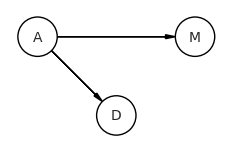

In [16]:
dag5_2 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")]
)
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [17]:
print(dag5_2.get_distribution())

P(A)P(M|A)P(D|A)


### Multiple regression notation

Multiple regression adds more parameters and variables to the difinition of $\mu_i$. The strategy is straightforward:

(1) Nominate the predictor variables you want in the linear model of the mean
(2) For each predictor, make a parameter that will measure its association with the outcome.
(3) Multiply the parameter by the variable and add that term to the linear model.

Hear is the model that predicts divorce rate, using both marriage rate and age at marriage

$$ D_i \sim Normal(\mu_i, \sigma) $$
$$ \mu_i = \alpha + \beta_M M_i + \beta_A A_i $$
$$ \alpha \sim Normal(0, 0.2) $$
$$ \beta_M \sim Normal(0, 0.5) $$
$$ \beta_A \sim Normal(0, 0.5) $$
$$ \sigma \sim Exponential(1) $$

In [18]:
with pm.Model() as m_5_3:
    a = pm.Normal('a', 0, 0.2)
    bA = pm.Normal('bA', 0, 0.5)
    bM = pm.Normal('bM', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bM*data.Marriage_std + bA*data.MedianAgeMarriage_std)
    divorce_rate_std = pm.Normal(
        'divorce_rate_std', mu=mu, sigma=sigma, observed=data.Divorce_std.values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [19]:
az.summary(m_5_3_trace, var_names=['a', 'bM', 'bA', 'sigma'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.10,-0.17,0.19,0.0,0.0,3416.63,2100.41,3419.48,2809.47,1.0
bM,-0.07,0.16,-0.34,0.24,0.0,0.0,2306.03,1860.91,2311.70,2254.98,1.0
bA,-0.61,0.16,-0.91,-0.32,0.0,0.0,2224.48,2201.57,2223.22,2689.67,1.0
sigma,0.83,0.09,0.67,0.99,0.0,0.0,3119.24,3093.43,3132.60,2706.86,1.0


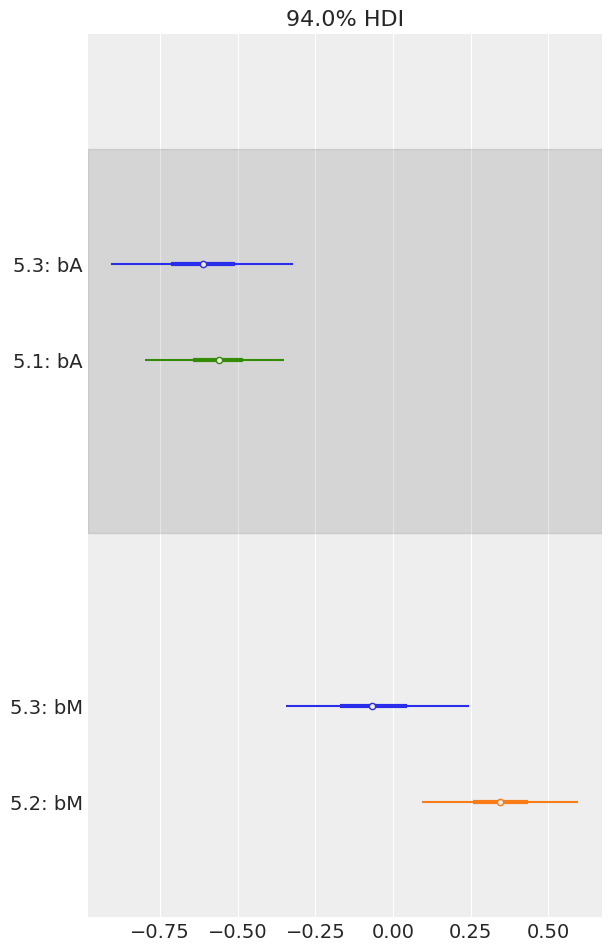

In [20]:
az.plot_forest(
    [
        m_5_3_trace,
        m_5_2_trace,
        m_5_1_trace,
    ],
    model_names=['5.3', '5.2', '5.1'],
    var_names = ['bA', 'bM'],
    combined=True
);

When comparing models as the above graph, we recognize that when adding Marriage Rate, the Median Age of Marriage does not change much (the uncertainty increases a little bit), but the Median Rate drop to zero. This might suggests that Median Age of Meriage does not

With multivariate regression, we need more plots

(1) **Predictor residual plots**: these plots show the outcome against *residual* predictor values. They are useful for understanding the statistical model, but not much else.

(2) **Posterior prediction plots**: These show model-based predictions agains raw data. They are tools for checking fit and assessing predictions. They are not causal tools

(3) **Couterfactual plots**: These show the implied predictions for imaginary experiments. These plots allow you to explore the causal implications of manipulating one or more variables.

#### Predictor Residual Plots
A predictor variable residual is the average prediction error when we use all of the other predictor variables to model a predictor of interest. We compute the residuals by subtracting the observed marriage rate in each State from the predicted rate, based upon the model 

$$ M_i \sim Normal(\mu_i, \sigma) $$
$$ \mu_i = \sigma + \beta A_i $$
$$ \alpha \sim Normal(0, 0.2) $$
$$ \beta \sim Normal(0, 0.5) $$
$$ \sigma \sim Exponential(1) $$

In [21]:
with pm.Model() as m_5_4:
    a = pm.Normal("a", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bAM * data.MedianAgeMarriage_std)
    marriage_std = pm.Normal(
        "marriage_std", mu=mu, sigma=sigma, observed=data.Marriage_std.values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


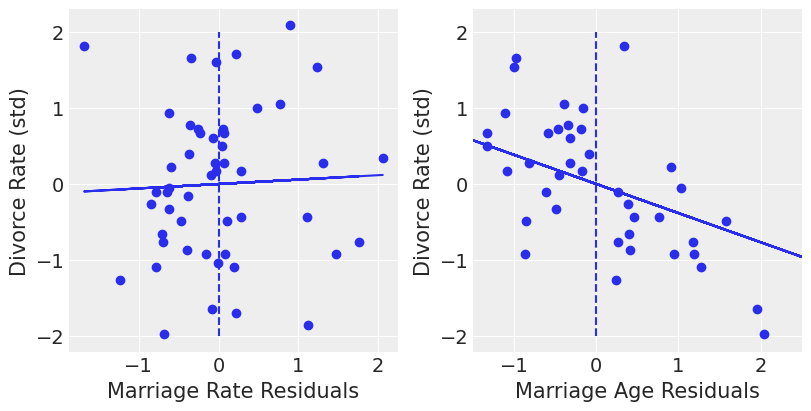

In [24]:
residualsM = data.Marriage_std - m_5_3_trace['mu'].mean(axis=0)
residualsA = data.MedianAgeMarriage_std - m_5_3_trace['mu'].mean(axis=0)

resreg_MD = LinearRegression().fit(residualsM.values.reshape(-1,1), data.Divorce_std)
resreg_AD = LinearRegression().fit(residualsA.values.reshape(-1,1), data.Divorce_std)


fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].scatter(residualsM, data.Divorce_std)
ax[0].vlines(0, -2, 2, linestyles='--')
ax[0].plot(residualsM, resreg_MD.predict(residualsM.values.reshape(-1, 1)))
ax[0].set_xlabel('Marriage Rate Residuals')
ax[0].set_ylabel('Divorce Rate (std)')
ax[1].scatter(residualsA, data.Divorce_std)
ax[1].vlines(0, -2, 2, linestyles='--')
ax[1].plot(residualsA, resreg_AD.predict(residualsA.values.reshape(-1, 1)))
ax[1].set_xlim(-1.5,2.5)
ax[1].set_xlabel('Marriage Age Residuals')
ax[1].set_ylabel('Divorce Rate (std)');

There's conceptual value in seeing the model-based predictions displayed against the outcome, after subtracting out the influence of other predictors. This procedure also brings home the message that regression models measure the remaining association of each predictor with the outcome, after alreadying knowing the other predictors.

**Notice: Never use residuals as data**.

### Posterior prediction plots

It's important to check the model's implied predictions against the observed data.There are 2 uses of checks

(1) Did the model correctly approximate the posterior distribution? Golems do make mistakes, as do golem engineers. Errors can be more easily diagnosed by comparing implied predictions to the raw data.

(2) How does the model fail?

How could we produce a simple posterior predictive check in the divorce example?

In [25]:
with m_5_3:
    m_5_3_ppc = pm.sample_posterior_predictive(
        m_5_3_trace, var_names=['mu', 'divorce_rate_std'], samples=1000
    )
    
mu_mean = m_5_3_ppc['mu'].mean(axis=0)
mu_hpd = az.hdi(m_5_3_ppc['mu'], 0.89)

D_sim = m_5_3_ppc['divorce_rate_std'].mean(axis=0)
D_PI = az.hdi(m_5_3_ppc['divorce_rate_std'], 0.89)

/home/telescreen/miniconda3/envs/data/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


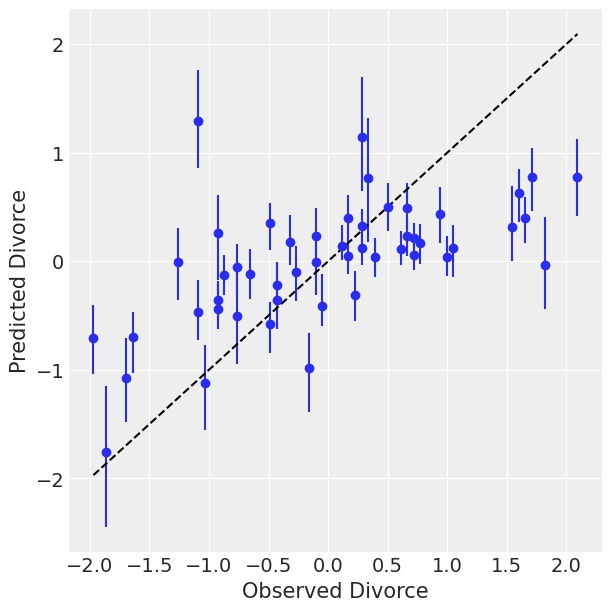

In [27]:
fig, ax = plt.subplots(figsize=(6,6))
ax.errorbar(data.Divorce_std, m_5_3_ppc['divorce_rate_std'].mean(0),
            yerr=np.abs(m_5_3_ppc['divorce_rate_std'].mean(0) - mu_hpd.T),
            fmt='C0o')
min_x, max_x = data.Divorce_std.min(), data.Divorce_std.max()
ax.plot([min_x, max_x], [min_x, max_x], 'k--')
ax.set_ylabel('Predicted Divorce')
ax.set_xlabel('Observed Divorce');

**Overthinking: Simulating spurious association**: One way that spurious associations between a predictor and outcome can arise is when a truly causal predictor, $x_{real}$ influances both the outcome $y$ and a spurious predictor $x_{spur}$. We simulate this scenario to prove that multiple regression can reliably indicate the right predictor.

In [39]:
with pm.Model() as m5_3_A:
    # A -> D <- M
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM*data.Marriage_std + bA*data.MedianAgeMarriage_std)
    divorce = pm.Normal("divorce", mu, sigma, observed=data.Divorce_std)

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM*data.MedianAgeMarriage_std)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data.Marriage_std)
    
    m_5_3_A_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aM, bAM, sigma_m, sigma, bA, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [40]:
A_seq = np.linspace(-2, 2, 50)
A_seq.shape

(50,)